This notebook shows how to **optimize** the **parameters** of a **scalar field** so it matches another **scalar field**.

The idea is that we define both the **optimized** and **target scalar fields** using **SDFs** and **post-processing functions**, then we compute a **cost function** based on how **similar** the **two fields** are at **every point in space**. We **tune** the **parameters** and **repeat** until the **cost function converges** and hopefully, the **fields** are as **similar as possible**.

We use **SDFs** and **post-processing functions** because by using **automatic differentiation (*JAX*)** it is relatively easy to compute the **gradient** of the **scalar field** at **every point in space** with **respect** to its **parameters**. This enables us to use **gradient-based minimization/optimization algorithms** (*Gradient Descent, ADAM, etc.*) to tune the **parameters** of the **optimized field**. In this example we use an **optimizer** found in ***Optax***.

Essentially, this is a very basic example of ***shape optimization***.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from jax import jacfwd, value_and_grad, config
import jax.numpy as jnp
import optax

from spomso.cores.helper_functions import generate_grid, smarter_reshape
from spomso.jax_cores.sdf_2D_jax import sdf_circle
from spomso.jax_cores.transformations_jax import compound_euclidian_transform_sdf
from spomso.jax_cores.modifications_jax import gaussian_falloff


config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

# PARAMETERS

In [2]:
# size of the volume
co_size = 8, 8
# resolution of the volume
co_resolution = 400, 400

show = "FIELD"  # FIELD, TARGET, OBJECTIVE
show_midplane = True
show_3d = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# SDF PARAMETERS

Both the **optimized/dynamic field** and the **target field** are defined using **SDFs**. 
To keep things simple both the **dynamic** and the **target field** have the same spatial dependance (**smoothed circle**), the only difference is in the **origin/position** of the fields. The **origin/position** of the fields will be the only **free parameter**.

Define the **radius** of the **smoothed circle**:

In [4]:
radius = 1.

Define the **initial position** of the **smoothed circle**:

In [5]:
x = 0.0
y = 0.0

Define the **target position** of the **smoothed circle**:

In [6]:
x_target = 2.5
y_target = -1.0

The **optimization** can also be done using **pure SDFs (circle)** - without any additional **post-processing** functions.

In [7]:
pure_sdf = False

# CREATE SDFs

Eventhough both the **dynamic** and **target fields** are (in this case) the same mathematically, we define them seperatly for the sake generality. 

Define a **target field** where the input is the **target position** of the **smoothed circle**:

In [8]:
def target_circle(x0, y0):
    vec = jnp.asarray([x0, y0, 0])

    if pure_sdf:
        out = compound_euclidian_transform_sdf(sdf_circle, jnp.eye(3), vec, 1.)(coor, radius)
    else:
        circle = gaussian_falloff(sdf_circle, 1., 0.5)
        circle = compound_euclidian_transform_sdf(circle, jnp.eye(3), vec, 1.)
        out = circle(coor, radius)

    return out

Define the **dynamic field** of the **smoothed circle** where the input is its **position**:

In [9]:
def smoothed_circle(vec):
    co = jnp.subtract(coor.T, vec).T + 0.001

    if pure_sdf:
        out = sdf_circle(co, radius)
    else:
        circle = gaussian_falloff(sdf_circle, 1., 0.5)
        out = circle(co, radius)

    return out

Define the **objective/cost function**, where the inputs are the **smoothed circle field** and the **target field**:

In [10]:
def objective_function(f_, t_):
    m = (f_ - t_)**2
    return m

# PRECOMPUTE

Compute the **target field**:

In [11]:
target_pattern = target_circle(x_target, y_target)

Define the **worker** for the **optax optimizer**. This function takes the **optimized parameters** as the *input* and *returns* the **value** of the **cost function**:

In [12]:
def worker(p):
    dynamic_pattern = smoothed_circle(p)
    out = objective_function(dynamic_pattern, target_pattern)
    out = jnp.sum(out)
    return out

## PLOT TARGET FIELD

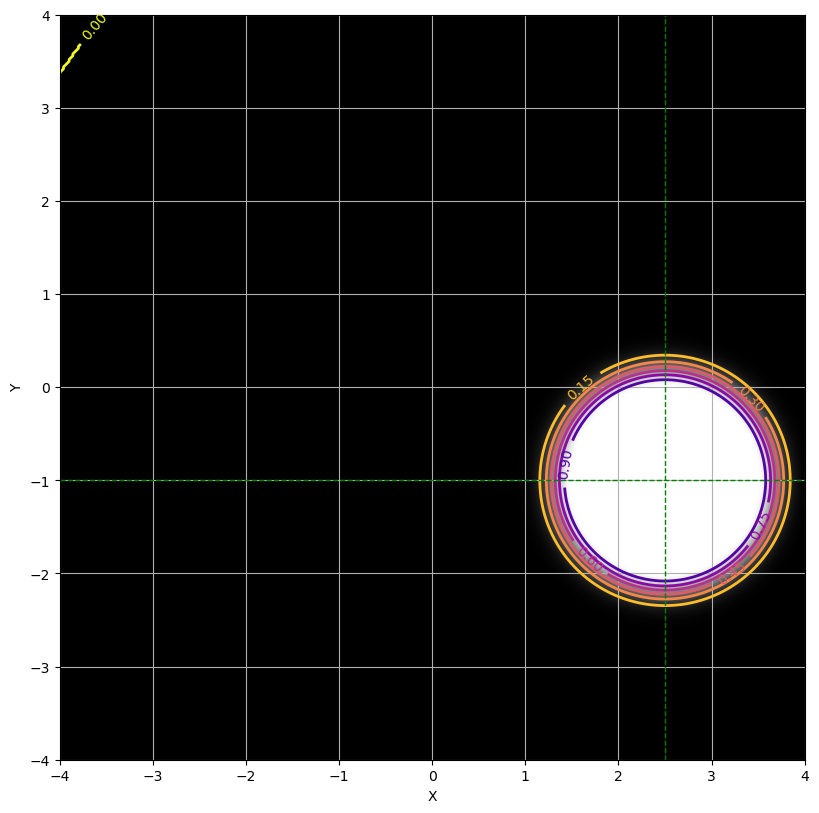

In [13]:
if show_midplane and (show=="TARGET" or show=="FIELD"):
    target_field = smarter_reshape(target_pattern, co_resolution)
    fig, ax = plt.subplots(1, 1, figsize=(8.25, 8.25))
    ax.imshow(target_field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs1 = ax.contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    target_field[:, :],
                    cmap="plasma_r",
                    linewidths=2)
    ax.clabel(cs1, inline=True, fontsize=10)
    ax.axvline(x=x_target, color='green', linestyle='--', linewidth=1)
    ax.axhline(y=y_target, color='green', linestyle='--', linewidth=1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid()
    fig.tight_layout()
    plt.show()

# OPTIMIZATION PARAMETERS

Maximum number of **optimization iterations**:

In [14]:
max_iterations = 500

The **optimizer** will **stop** when the **relative tolerance** of the **cost function** is **less** than this number:

In [15]:
relative_cost_difference = 1e-6

The **optimizer** will **stop** when the **cost function** is **less** than this number:

In [16]:
stop_cost_value = 1e-6

Start **learning rate** of the **optimizer**:

In [17]:
start_learning_rate = 0.05

# FIND SOLUTION

**Initialize parameters** of the **model** and **optimizer**:

In [18]:
params = jnp.array([x, y, 0])
optimizer = optax.adam(start_learning_rate)
opt_state = optimizer.init(params)

**Optimization/update loop:**

In [19]:
prev_value = 1e16
best_value, best_params = 1e16, jnp.array([x, y, 0])
for i in range(max_iterations):
    value, grads = value_and_grad(worker)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    print(f"Iteration: {i + 1}", "Value:", value, "Parameters:", params, "Gradient:", grads)

    if value < stop_cost_value:
        break

    rtol = jnp.abs(value / prev_value - 1)
    if rtol < relative_cost_difference:
        break
    else:
        prev_value = value.copy()
        print("Relative tolerance:", rtol)

    if value < best_value:
        best_value, best_params = value, params.copy()

    params = optax.apply_updates(params, updates)

Iteration: 1 Value: 21100.25256464005 Parameters: [0. 0. 0.] Gradient: [-218.00192545   87.71782941   -0.        ]
Relative tolerance: 0.99999999999789
Iteration: 2 Value: 21078.886646196697 Parameters: [ 0.05 -0.05  0.  ] Gradient: [-411.60927281  159.12081861   -0.        ]
Relative tolerance: 0.001012590649230316
Iteration: 3 Value: 21041.97268417683 Parameters: [ 0.09855814 -0.09875557  0.        ] Gradient: [-708.74588069  265.76600963   -0.        ]
Relative tolerance: 0.0017512292105108518
Iteration: 4 Value: 20983.066319476864 Parameters: [ 0.14586138 -0.14638982  0.        ] Gradient: [-1130.60135311   409.4208366     -0.        ]
Relative tolerance: 0.002799469687757128
Iteration: 5 Value: 20895.06206114273 Parameters: [ 0.19235193 -0.19334478  0.        ] Gradient: [-1677.95520532   585.13948957    -0.        ]
Relative tolerance: 0.004194060915322373
Iteration: 6 Value: 20770.6884127941 Parameters: [ 0.23852268 -0.24010046  0.        ] Gradient: [-2340.61016409   785.956560

## Final results:

In [20]:
value, grads = value_and_grad(worker)(params)
if value > best_value:
    value, params = best_value, best_params.copy()

print("\nFinal results:", "\nValue:", value, "\nParameters:", params, "\nGradient:", grads, "\n")


Final results: 
Value: 2.235477783598616e-07 
Parameters: [ 2.50100047 -0.99900304  0.        ] 
Gradient: [ 0.02235085 -0.14358162 -0.        ] 



# EVALUATE SOLUTION

In [21]:
x_solution, y_solution, z_solution = tuple(params)

if show == "OBJECTIVE":
    def shown_field(x_, y_): return objective_function(smoothed_circle(jnp.asarray([x_, y_, 0])),
                                                       target_circle(x_target, y_target))
else:
    def shown_field(x_, y_): return smoothed_circle(jnp.asarray([x_, y_, 0]))

Evaluate the **SDF** of the **geometry** to create a signed distance field 2D map.

In [22]:
final_pattern = shown_field(x_solution, y_solution)

Calculate the **Jacobian** with respect to the **x-position** (argnums=0), **y-position** (argnums=1):

In [23]:
gradient_pattern = jacfwd(shown_field, argnums=0)(x_solution, y_solution)

Convert the **final pattern** and the **gradient pattern** into 2D images:

In [24]:
field = smarter_reshape(final_pattern, co_resolution)
gradient_field = smarter_reshape(gradient_pattern, co_resolution)

# PLOT

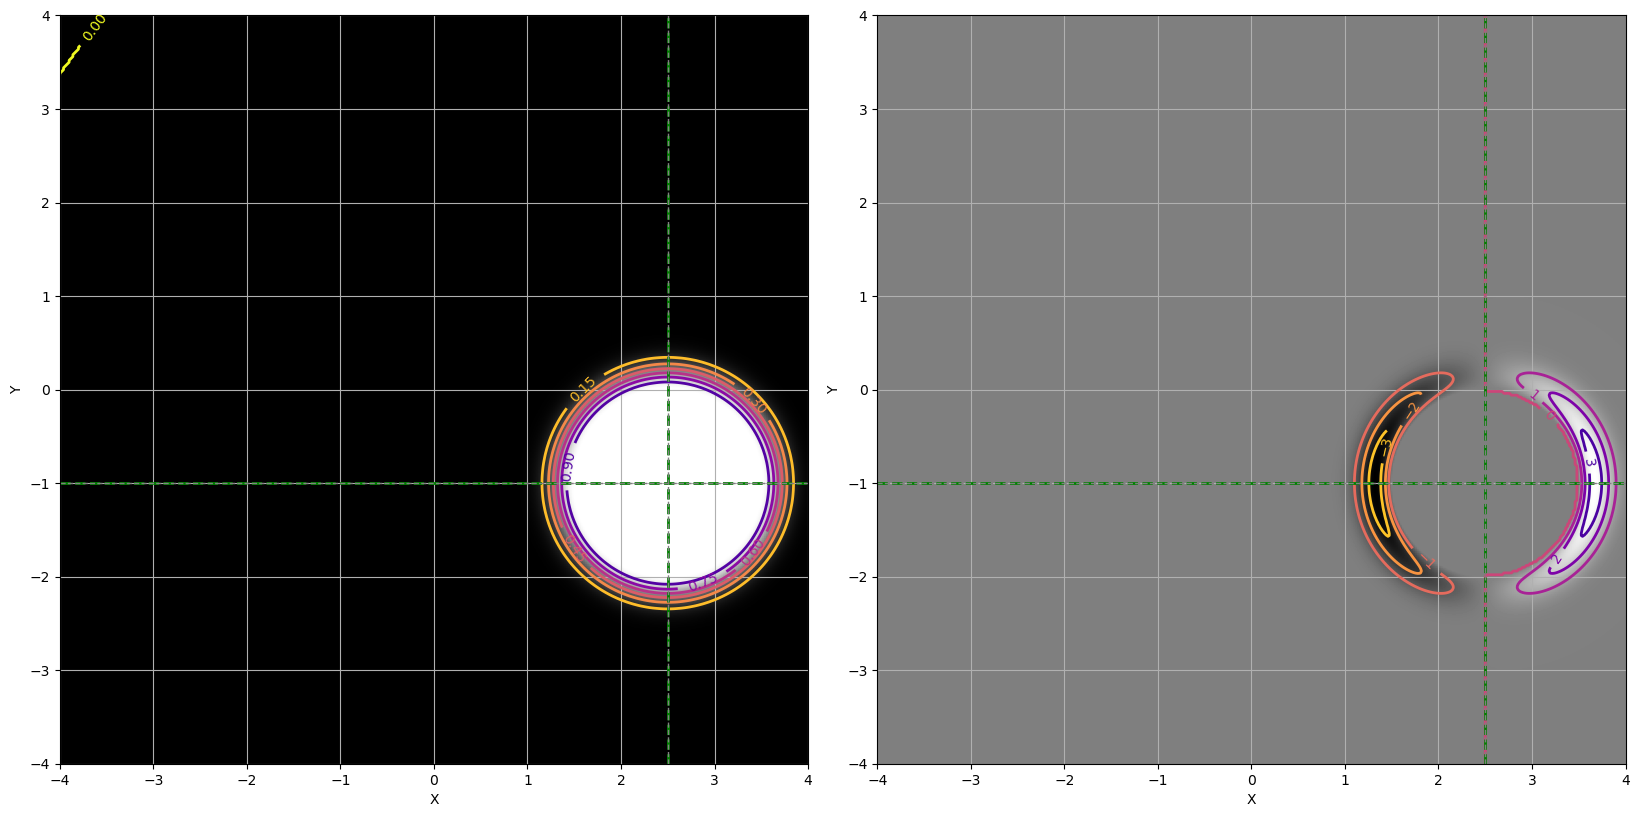

In [25]:
if show_midplane:
    fig, axs = plt.subplots(1, 2, figsize=(2*8.25, 8.25))

    # FIELD
    axs[0].imshow(field[:, :].T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    cs1 = axs[0].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                    coor[1].reshape(co_res_new[0], co_res_new[1]),
                    field[:, :],
                    cmap="plasma_r",
                    linewidths=2)
    axs[0].clabel(cs1, inline=True, fontsize=10)
    axs[0].grid()
    axs[0].axvline(x=x_target, color='green', linestyle='--', linewidth=2)
    axs[0].axhline(y=y_target, color='green', linestyle='--', linewidth=2)
    axs[0].axvline(x=x_solution, color='grey', linestyle='--', linewidth=1)
    axs[0].axhline(y=y_solution, color='grey', linestyle='--', linewidth=1)

    # GRADIENT
    axs[1].imshow(gradient_field[:, :].T,
                  cmap="binary_r",
                  extent=(-co_size[0] / 2, co_size[0] / 2,
                          -co_size[1] / 2, co_size[1] / 2),
                  origin="lower"
                  )
    cs2 = axs[1].contour(coor[0].reshape(co_res_new[0], co_res_new[1]),
                        coor[1].reshape(co_res_new[0], co_res_new[1]),
                        gradient_field[:, :],
                        cmap="plasma_r",
                        linewidths=2)
    axs[1].clabel(cs2, inline=True, fontsize=10)
    axs[1].grid()
    axs[1].axvline(x=x_target, color='green', linestyle='--', linewidth=2)
    axs[1].axhline(y=y_target, color='green', linestyle='--', linewidth=2)
    axs[1].axvline(x=x_solution, color='grey', linestyle='--', linewidth=1)
    axs[1].axhline(y=y_solution, color='grey', linestyle='--', linewidth=1)

    for ax in axs:
        ax.set_xlabel("X")
        ax.set_ylabel("Y")

    fig.tight_layout()
    plt.show()

In [ ]:
if show_3d:
    patterns = ((field, gradient_field),)
    titles = ("Field", "Gradient")

    fig = make_subplots(rows=1, cols=2,
                        specs=[[{'is_3d': True}, {'is_3d': True}]],
                        subplot_titles=titles
                        )

    for i in range(1):
        for j in range(2):
            fig.add_trace(go.Surface(x=coor[0].reshape(co_res_new[0], co_res_new[1]),
                                     y=coor[1].reshape(co_res_new[0], co_res_new[1]),
                                     z=patterns[i][j][:, :],
                                     contours={
                                         "z": {"show": True,
                                               "start": np.floor(np.amin(patterns[i][j][:, :]*10))/10,
                                               "end": np.ceil(np.amax(patterns[i][j][:, :]*10))/10,
                                               "size": 0.1}
                                     },
                                     cmin=0,
                                     cmax=1),
                          1 + i, 1 + j,
                          )

            fig.update_traces(contours_z=dict(show=True, usecolormap=False,
                                              highlightcolor="limegreen", project_z=True))

    fig.show()
